In [2]:
import sys
sys.path.append("../")

from detect import Detector
import torch

device = "cuda:0" if torch.cuda.is_available() else "cpu"

detector = Detector(
    weight_detect="/mnt/data/src/text_detection/yolo/runs/obb/train3/weights/best.pt",
    threshold=0.5,
    iou=0.2,
    device=device,
    batch_size=64,
)

results = detector.detect("/mnt/data/data/Data_Ve_Chu/YOLO_2608/val")
len(results)


0: 224x224 4.2ms
1: 224x224 4.2ms
2: 224x224 4.2ms
3: 224x224 4.2ms
4: 224x224 4.2ms
5: 224x224 4.2ms
6: 224x224 4.2ms
7: 224x224 4.2ms
8: 224x224 4.2ms
9: 224x224 4.2ms
10: 224x224 4.2ms
11: 224x224 4.2ms
12: 224x224 4.2ms
13: 224x224 4.2ms
14: 224x224 4.2ms
15: 224x224 4.2ms
16: 224x224 4.2ms
17: 224x224 4.2ms
18: 224x224 4.2ms
19: 224x224 4.2ms
20: 224x224 4.2ms
21: 224x224 4.2ms
22: 224x224 4.2ms
23: 224x224 4.2ms
24: 224x224 4.2ms
25: 224x224 4.2ms
26: 224x224 4.2ms
27: 224x224 4.2ms
28: 224x224 4.2ms
29: 224x224 4.2ms
30: 224x224 4.2ms
31: 224x224 4.2ms
32: 224x224 (no detections), 4.2ms
33: 224x224 4.2ms
34: 224x224 4.2ms
35: 224x224 4.2ms
36: 224x224 4.2ms
37: 224x224 (no detections), 4.2ms
38: 224x224 4.2ms
39: 224x224 4.2ms
40: 224x224 4.2ms
41: 224x224 4.2ms
42: 224x224 4.2ms
43: 224x224 4.2ms
44: 224x224 4.2ms
45: 224x224 4.2ms
46: 224x224 4.2ms
47: 224x224 4.2ms
48: 224x224 (no detections), 4.2ms
49: 224x224 4.2ms
50: 224x224 4.2ms
51: 224x224 4.2ms
52: 224x224 4.2ms
53: 

506

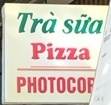

In [104]:
from random import randint

random_index = randint(0, len(results))
sample_result = list(results.values())[random_index]
Image.open(sample_result.path)

In [105]:
obb = sample_result.obb[0]
obb

ultralytics.engine.results.OBB object with attributes:

cls: tensor([0.], device='cuda:0')
conf: tensor([0.9487], device='cuda:0')
data: tensor([[3.6296e+01, 2.1457e+01, 4.7870e+01, 2.7665e+01, 4.3749e-02, 9.4866e-01, 0.0000e+00]], device='cuda:0')
id: None
is_track: False
orig_shape: (105, 111)
shape: torch.Size([1, 7])
xywhr: tensor([[3.6296e+01, 2.1457e+01, 4.7870e+01, 2.7665e+01, 4.3749e-02]], device='cuda:0')
xyxy: tensor([[11.7793,  6.5904, 60.8132, 36.3228]], device='cuda:0')
xyxyxyxy: tensor([[[59.6033, 36.3228],
         [60.8132,  8.6840],
         [12.9892,  6.5904],
         [11.7793, 34.2292]]], device='cuda:0')
xyxyxyxyn: tensor([[[0.5370, 0.3459],
         [0.5479, 0.0827],
         [0.1170, 0.0628],
         [0.1061, 0.3260]]], device='cuda:0')

In [106]:
import numpy as np
import cv2
from PIL import Image

def obb_to_perspective_view(image_path, obb) -> Image:
    """
    Crops an oriented bounding box (OBB) and returns it as a PIL.Image in perspective view.

    Args:
        image (str): Original image path.
        obb (np.ndarray): Oriented bounding box coordinates, shape (4, 2).

    Returns:
        PIL.Image: Cropped OBB as a perspective-view PIL image.
    """
    # Read the image
    image = cv2.imread(image_path)

    # Convert OBB points to a numpy array of float32
    obb_points = np.array(obb, dtype=np.float32)

    # Compute the width and height of the bounding box
    (tl, tr, br, bl) = obb_points
    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)

    max_width = max(int(widthA), int(widthB))
    max_height = max(int(heightA), int(heightB))

    # Define the destination points for the perspective transform
    dst = np.array([
        [0, 0],
        [max_width - 1, 0],
        [max_width - 1, max_height - 1],
        [0, max_height - 1]], dtype=np.float32)

    # Get the perspective transform matrix
    M = cv2.getPerspectiveTransform(obb_points, dst)

    # Apply the perspective warp to get the cropped OBB
    warped = cv2.warpPerspective(image, M, (max_width, max_height))

    # Convert the warped image to PIL format (from BGR to RGB for PIL compatibility)
    warped_rgb = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(warped_rgb)

    return pil_image

In [107]:
def order_obb_points(obb):
    """
    Orders the 4 points of the OBB as (tl, tr, br, bl).

    Args:
        obb (np.ndarray): Array of 4 points (x, y) in any order.

    Returns:
        np.ndarray: Ordered points (tl, tr, br, bl).
    """
    rect = np.zeros((4, 2), dtype="float32")

    # Sum of (x, y) will give us top-left and bottom-right
    s = obb.sum(axis=1)
    rect[0] = obb[np.argmin(s)]  # top-left
    rect[2] = obb[np.argmax(s)]  # bottom-right

    # Difference between (x, y) will give us top-right and bottom-left
    diff = np.diff(obb, axis=1)
    rect[1] = obb[np.argmin(diff)]  # top-right
    rect[3] = obb[np.argmax(diff)]  # bottom-left

    return rect

In [108]:
from PIL import Image, ImageDraw

for obb_object in sample_result.obb:
    image_path = sample_result.path
    obb = obb_object.xyxyxyxy[0].cpu().numpy()
    bb = obb_object.xyxy[0].cpu().numpy() 

    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    draw.rectangle([*bb], width=2, outline="red")
    draw.polygon([tuple(point) for point in obb], width=2, outline="green")
    # display(image)

    obb = order_obb_points(obb)
    pil_image = obb_to_perspective_view(image_path, obb)
    display(pil_image)
    # break